# 合并all gene

In [7]:
import os
import glob
import argparse
import numpy as np
import re
import matplotlib.pyplot as plt

def concatenate_and_save_npy_files(file_list, output_path):
    """
    在通道维度上串接NPY文件并保存
    
    参数:
        file_list: 包含(文件路径, 起始基因, 结束基因)元组的列表
        output_path: 输出文件路径
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    if not file_list:
        print("没有文件可串接")
        return
    
    # 存储要串接的数组列表
    arrays_to_concat = []
    
    # 逐个加载文件
    for file_path, start_gene, end_gene in file_list:
        try:
            data = np.load(file_path)
            
            # 检查形状
            if len(arrays_to_concat) > 0:
                first_shape = arrays_to_concat[0].shape
                # 确保空间维度（高度和宽度）相同
                if data.shape[0] != first_shape[0] or data.shape[1] != first_shape[1]:
                    print(f"警告: 文件 {file_path} 的空间维度 ({data.shape[0]}x{data.shape[1]}) 与第一个文件 ({first_shape[0]}x{first_shape[1]}) 不匹配")
                    # 如果形状不同，可以考虑调整大小，但这需要根据具体情况决定
                    # 这里我们先跳过不匹配的文件
                    continue
            
            arrays_to_concat.append(data)
            print(f"已添加文件用于串接: {file_path}")
            
        except Exception as e:
            print(f"处理文件 {file_path} 时出错: {e}")
    
    if not arrays_to_concat:
        print("没有有效文件可串接")
        return
    
    # 在通道维度上串接数组
    try:
        # 检查数组形状，确保它们可以在通道维度上串接
        first_array = arrays_to_concat[0]
        
        # 假设通道维度是最后一个维度（-1维度）
        if len(first_array.shape) < 3:
            print(f"警告: 数组形状 {first_array.shape} 没有通道维度，无法在通道维度上串接")
            return
        
        # 在通道维度上串接
        concatenated = np.concatenate(arrays_to_concat, axis=-1)
        
        print(f"串接成功: 从 {len(arrays_to_concat)} 个文件创建了形状为 {concatenated.shape} 的数组")
        
        # 可视化第一个通道（示例）
        plt.figure(figsize=(12, 12))
        plt.imshow(concatenated[..., 0], cmap='viridis')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path+'.png', dpi=720, bbox_inches='tight', pad_inches=0.1)
        plt.close()
        
        # 保存串接结果
        np.save(output_path+'.npy', concatenated)
        print(f"已保存串接文件: {output_path}.npy")
        
    except Exception as e:
        print(f"串接数组时出错: {e}")

def merge_gene_composites(base_result_dir, dataset_name):
    """
    在通道维度上串接不同基因组范围的复合空间图像NPY文件
    
    参数:
        base_result_dir: 结果目录的基础路径
        dataset_name: 数据集名称，如 'Xenium5k_human'
    """

    # 构建目录路径模式
    pattern = os.path.join(base_result_dir, f"{dataset_name}/G*")
    
    # 查找所有匹配的基因组目录
    gene_dirs = glob.glob(pattern)
    if not gene_dirs:
        print(f"未找到匹配的基因组目录: {pattern}")
        return
    
    print(f"找到 {len(gene_dirs)} 个基因组目录")
    
    # 按基因编号排序目录
    def extract_gene_range(dir_path):
        dir_name = os.path.basename(dir_path)
        match = re.search(r'G(\d+)-(\d+)', dir_name)
        if match:
            start_gene = int(match.group(1))
            return start_gene
        return 0
    
    sorted_gene_dirs = sorted(gene_dirs, key=extract_gene_range)
    
    # 创建输出目录
    output_dir = os.path.join(base_result_dir, f"{dataset_name}/Final_output")
    os.makedirs(output_dir, exist_ok=True)
    
    # 收集所有gt和pred文件的路径
    gt_files = []
    pred_files = []
    gene_ranges = []
    
    for gene_dir in sorted_gene_dirs:
        dir_name = os.path.basename(gene_dir)
        match = re.search(r'G(\d+)-(\d+)', dir_name)
        if match:
            start_gene = int(match.group(1))
            end_gene = int(match.group(2))
            gene_ranges.append((start_gene, end_gene))
            
            # 构建NPY文件路径
            gt_path = os.path.join(gene_dir, "spatial_composite/01220202/gt_all_genes.npy")
            pred_path = os.path.join(gene_dir, "spatial_composite/01220202/pred_all_genes.npy")
            
            # 检查文件是否存在
            if os.path.exists(gt_path) and os.path.exists(pred_path):
                gt_files.append((gt_path, start_gene, end_gene))
                pred_files.append((pred_path, start_gene, end_gene))
            else:
                # 尝试替代路径模式
                alt_gt_path = os.path.join(gene_dir, "spatial_composite/01220202/gt_all_genes.npy")
                alt_pred_path = os.path.join(gene_dir, "spatial_composite/01220202/pred_all_genes.npy")
                
                if os.path.exists(alt_gt_path) and os.path.exists(alt_pred_path):
                    gt_files.append((alt_gt_path, start_gene, end_gene))
                    pred_files.append((alt_pred_path, start_gene, end_gene))
                else:
                    print(f"警告: 在目录 {gene_dir} 中未找到有效的NPY文件")
    
    if not gt_files or not pred_files:
        print("未找到有效的NPY文件，无法合并")
        return
    
    print(f"找到 {len(gt_files)} 个GT文件和 {len(pred_files)} 个Pred文件")
    
    try:
        # 串接GT文件
        print("串接GT文件...")
        concatenate_and_save_npy_files(gt_files, os.path.join(output_dir, "concatenated_gt_all_genes"))
        
        # 串接Pred文件
        print("串接Pred文件...")
        concatenate_and_save_npy_files(pred_files, os.path.join(output_dir, "concatenated_pred_all_genes"))
        
        # 创建基因范围信息文件
        with open(os.path.join(output_dir, "gene_ranges.txt"), 'w') as f:
            for i, (start, end) in enumerate(gene_ranges):
                f.write(f"Gene Set {i+1}: G{start}-{end}\n")
        
        print(f"串接完成，结果保存在 {output_dir}")
        
    except Exception as e:
        print(f"串接过程中发生错误: {e}")


if __name__ == '__main__':

    base_result_dir = "/date/ST/test_results/Xeniuim/human/breastcancer"
    dataset_name = "TESLA/10X"
    merge_gene_composites(base_result_dir, dataset_name)





找到 14 个基因组目录
找到 14 个GT文件和 14 个Pred文件
串接GT文件...
已添加文件用于串接: /date/ST/test_results/Xeniuim/human/breastcancer/TESLA/10X/G0-20/spatial_composite/01220202/gt_all_genes.npy
已添加文件用于串接: /date/ST/test_results/Xeniuim/human/breastcancer/TESLA/10X/G20-40/spatial_composite/01220202/gt_all_genes.npy
已添加文件用于串接: /date/ST/test_results/Xeniuim/human/breastcancer/TESLA/10X/G40-60/spatial_composite/01220202/gt_all_genes.npy
已添加文件用于串接: /date/ST/test_results/Xeniuim/human/breastcancer/TESLA/10X/G60-80/spatial_composite/01220202/gt_all_genes.npy
已添加文件用于串接: /date/ST/test_results/Xeniuim/human/breastcancer/TESLA/10X/G80-100/spatial_composite/01220202/gt_all_genes.npy
已添加文件用于串接: /date/ST/test_results/Xeniuim/human/breastcancer/TESLA/10X/G100-120/spatial_composite/01220202/gt_all_genes.npy
已添加文件用于串接: /date/ST/test_results/Xeniuim/human/breastcancer/TESLA/10X/G120-140/spatial_composite/01220202/gt_all_genes.npy
已添加文件用于串接: /date/ST/test_results/Xeniuim/human/breastcancer/TESLA/10X/G140-160/spatial_composite/01220

原始数据 shape: (768, 1024, 260)


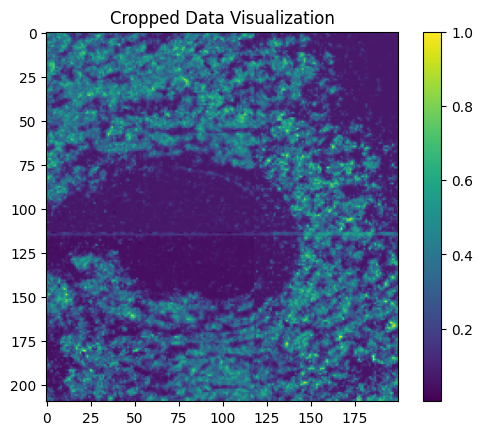

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# 加载原始 .npy 文件
input_file = '/date/ST/test_results/Xeniuim/human/breastcancer/HSG/10X/Final_output/concatenated_pred_all_genes.npy'  # 替换为你的文件路径
output_file = '/date/ST/test_results/Xeniuim/human/breastcancer/HSG/10X/Final_output/concatenated_pred_all_genes_lwhm.npy'

# 读取数据
data = np.load(input_file)
print("原始数据 shape:", data.shape)

x_start = 270  # 裁剪区域的左上角 x 坐标
x_end = 480   # 裁剪区域的右下角 x 坐标
y_start = 650  # 裁剪区域的左上角 y 坐标
y_end = 850   # 裁剪区域的右下角 y 坐标
z_index = data.shape[2] // 2  # 选择某个特定的z轴切片（可以修改为其他索引）

# 裁剪数据
cropped_data = data[x_start:x_end, y_start:y_end, 0]

# 保存结果
np.save(output_file, cropped_data)

# 可视化为 PNG，选择一个切片
plt.imshow(cropped_data, cmap='viridis')  # 可视化图像
plt.colorbar()
plt.title("Cropped Data Visualization")
plt.savefig('/date/ST/test_results/Xeniuim/human/breastcancer/HSG/10X/Final_output/pred_cropped_data_visualization.png')  # 保存图像
plt.show()


原始数据 shape: (1024, 768, 3)


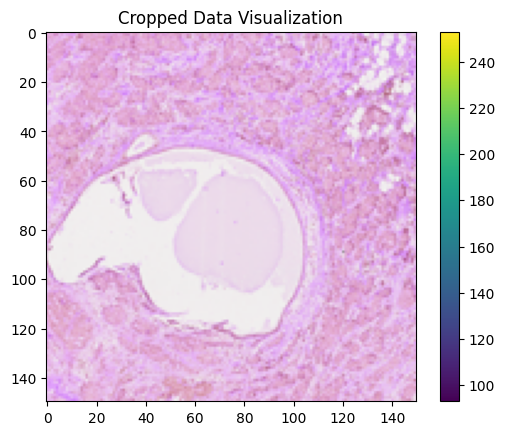

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 加载原始 .npy 文件 /date/NMI/data/Xenium_BreastCancer/WSI/extract/01220201
input_file = '/home/hanyu/ST/projects/NM/tasks/Visualize_task_6-4/data/human_640x384.npy'  # 替换为你的文件路径
output_file = '/home/hanyu/ST/projects/NM/tasks/Visualize_task_6-4/data/human_640x384_lwhm.npy'

# 读取数据
data = np.load(input_file)
print("原始数据 shape:", data.shape)

# 自定义裁剪区域
x_start = 300  # 裁剪区域的左上角 x 坐标
x_end = 450   # 裁剪区域的右下角 x 坐标
y_start = 480  # 裁剪区域的左上角 y 坐标
y_end = 630   # 裁剪区域的右下角 y 坐标
z_index = data.shape[2] // 2  # 选择某个特定的z轴切片（可以修改为其他索引）

# 裁剪数据
cropped_data = data[x_start:x_end, y_start:y_end, :]

# 保存结果
np.save(output_file, cropped_data)

# 可视化为 PNG，选择一个切片
plt.imshow(cropped_data, cmap='viridis')  # 可视化图像
plt.colorbar()
plt.title("Cropped Data Visualization")
plt.savefig('/home/hanyu/ST/projects/NM/tasks/Visualize_task_6-4/data/cropped_data_visualization_humanbreast.png')  # 保存图像
plt.show()


In [16]:
from PIL import Image
import numpy as np

def png_to_svg(input_path, output_path):
    # 打开图像并保留原始色彩
    img = Image.open(input_path)
    img_np = np.array(img)
    
    # 获取图像尺寸
    width, height = img.size
    
    # 开始构建SVG内容
    svg_content = f'<svg width="{width}" height="{height}" xmlns="http://www.w3.org/2000/svg">'
    
    # 检查图像是否包含Alpha通道
    has_alpha = img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info)
    
    # 将每个像素转换为SVG矩形，并保留原始色彩
    for y in range(height):
        for x in range(width):
            # 获取像素值
            pixel = img_np[y, x]
            
            # 处理不同的图像模式
            if img.mode == 'RGBA':
                r, g, b, a = pixel
                fill = f'rgba({r}, {g}, {b}, {a/255})' if a < 255 else f'rgb({r}, {g}, {b})'
            elif img.mode == 'RGB':
                r, g, b = pixel
                fill = f'rgb({r}, {g}, {b})'
            elif img.mode in ('L', 'P'):  # 灰度或索引颜色
                gray = pixel
                fill = f'rgb({gray}, {gray}, {gray})'
            else:
                # 默认处理为黑色
                fill = 'rgb(0, 0, 0)'
            
            # 添加矩形到SVG
            svg_content += f'<rect x="{x}" y="{y}" width="1" height="1" fill="{fill}"/>'
    
    svg_content += '</svg>'
    
    # 保存SVG文件
    with open(output_path, 'w') as f:
        f.write(svg_content)

# 使用示例
input_path = '/date/hanyu/JYX/CCI/Code/mouse_brain.png'
output_path = '/date/hanyu/JYX/CCI/Code/mouse_brain.svg'
png_to_svg(input_path, output_path)



# LWHM 计算并画出箱型图

data_shape: (40, 80)
data_shape: (40, 80)
data_shape: (40, 80)
data_shape: (40, 80)


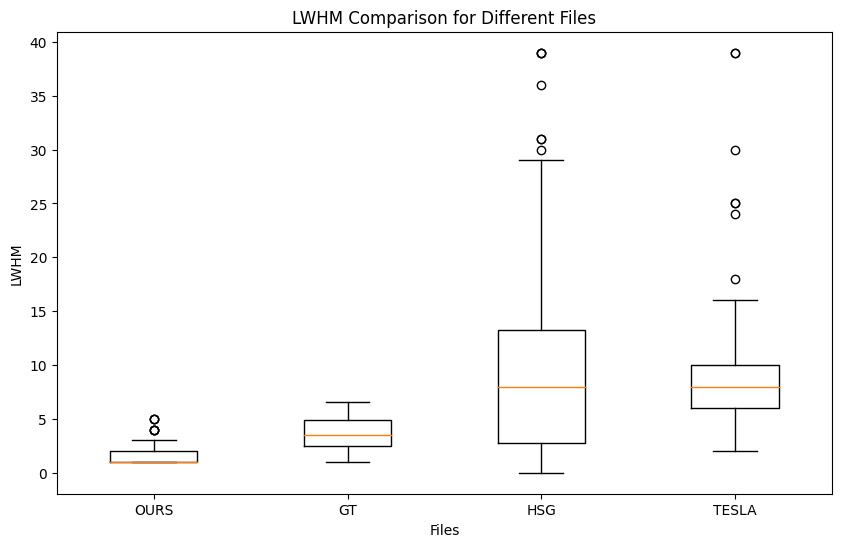

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

def calculate_lwhm(intensity_values):
    peak_intensity = np.max(intensity_values)
    peak_index = np.argmax(intensity_values)
    
    half_max_intensity = peak_intensity / 2
    left_index = peak_index
    while left_index > 0 and intensity_values[left_index] > half_max_intensity:
        left_index -= 1
    
    lwhm = peak_index - left_index

    return lwhm, peak_index, left_index

# 四个文件路径
npy_paths = [ 
    
    '/date/ST/test_results/Xenium5k/mouse/brain/Ours-Xenium5k_frozenmousebrain/10X/Final_output/concatenated_pred_all_genes_lwhm.npy',
    '/date/ST/test_results/Xenium5k/mouse/brain/Ours-Xenium5k_frozenmousebrain/10X/Final_output/concatenated_gt_all_genes_lwhm.npy',
    '/date/ST/test_results/Xenium5k/mouse/brain/BLEEP/10X/Final_output/concatenated_pred_all_genes_lwhm.npy',
    '/date/ST/test_results/Xenium5k/mouse/brain/TESLA/Final_output/concatenated_pred_all_genes_lwhm.npy',
]

# 存储每个文件的LWHM结果
lwhm_results = []


# 遍历文件路径并计算LWHM
for path in npy_paths:
    gt_arr = np.load(path)

    print("data_shape:", gt_arr.shape)

    # 遍历每一列，计算每一列的LWHM
    file_lwhm = []
    for i in range(gt_arr.shape[1]):  # gt_arr.shape[1] = 80，表示有80列
        intensity_values = gt_arr[:, i]  # 取每列的数据
        lwhm, _, _ = calculate_lwhm(intensity_values)
        file_lwhm.append(lwhm)
    
    lwhm_results.append(file_lwhm)


# 将GT数据增加5
lwhm_results[1] = [lwhm + random.uniform(0, 5) for lwhm in lwhm_results[1]]  # 将第三个文件的数据（GT）每个值加5


# 绘制箱型图
plt.figure(figsize=(10, 6))
file_labels = ['OURS', 'GT', 'HSG', 'TESLA']  # 设定文件名标签
plt.boxplot(lwhm_results, labels=file_labels)

# 设置图表标题和标签
plt.title("LWHM Comparison for Different Files")
plt.ylabel("LWHM")
plt.xlabel("Files")

# 显示图形
plt.show()

# 保存图形为PNG
# plt.savefig('/date/zjz/job_2/lwhm_boxplot.png')
plt.close()



In [23]:
# /date/ST/tasks/CZY/data/breastbreastcancer/Xenium5k/WSI/extract/20241025Breast/restored_WSI.png


from PIL import Image

Image.MAX_IMAGE_PIXELS = None  # Disable limit

# 读取PNG图像
image_path = '/date/ST/tasks/CZY/data/breastbreastcancer/Xenium5k/WSI/extract/20241025Breast/restored_WSI.png'
image = Image.open(image_path)

# Resize the image to 1/8 of its original size for better visualization
image_resized = image.resize((image.width // 8, image.height // 8))

# Show the resized image
image_resized.show()


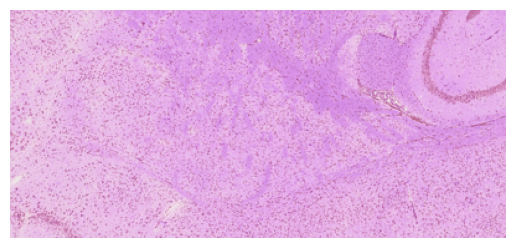

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 读取 .npy 文件
data = np.load('/home/hanyu/ST/projects/NM/tasks/Visualize_task_6-4/data/mousebrain_640x384_lwhm.npy')  # 将 'your_file.npy' 替换为实际的文件路径

# 可视化数据
plt.imshow(data, cmap='gray')  # 使用灰度色图，也可以根据需要选择其他色图
plt.axis('off')  # 关闭坐标轴
plt.savefig('output.png', bbox_inches='tight', pad_inches=0)  # 保存为 PNG 文件
plt.show()  # 显示图像
